In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

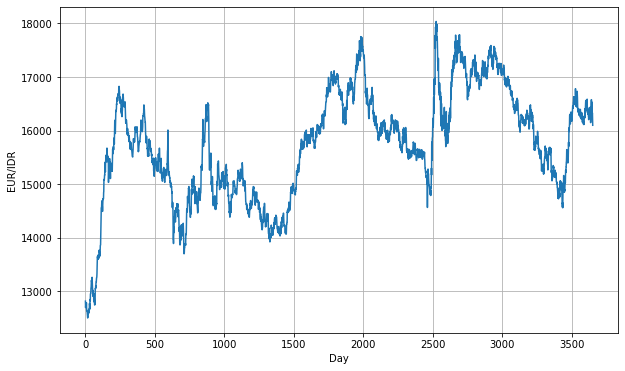

In [3]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./currency_data_10_years.csv') as csvfile:
  
    # Initialize reader
    reader = csv.reader(csvfile, delimiter=',')

    # Skip the first line
    next(reader)

    # Append row and sunspot number to lists
    for i,row in enumerate(reader):
        time_step.append(int(i))
        sunspots.append(float(row[1]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='EUR/IDR')

In [4]:
# Define the split time
split_time = 3200

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [6]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [7]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [8]:

# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)


In [9]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
100/100 [==============================] - 4s 29ms/step - loss: 669.9076 - lr: 1.0000e-08
Epoch 2/100
100/100 [==============================] - 1s 5ms/step - loss: 251.4834 - lr: 1.1220e-08
Epoch 3/100
100/100 [==============================] - 1s 6ms/step - loss: 267.0713 - lr: 1.2589e-08
Epoch 4/100
100/100 [==============================] - 1s 6ms/step - loss: 261.0143 - lr: 1.4125e-08
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 250.6356 - lr: 1.5849e-08
Epoch 6/100
100/100 [==============================] - 1s 7ms/step - loss: 242.5452 - lr: 1.7783e-08
Epoch 7/100
100/100 [==============================] - 1s 5ms/step - loss: 244.0894 - lr: 1.9953e-08
Epoch 8/100
100/100 [==============================] - 1s 7ms/step - loss: 232.8124 - lr: 2.2387e-08
Epoch 9/100
100/100 [==============================] - 1s 5ms/step - loss: 218.1347 - lr: 2.5119e-08
Epoch 10/100
100/100 [==============================] - 1s 5ms/step - loss: 274.2996 - lr:

100/100 [==============================] - 1s 5ms/step - loss: 15755.2266 - lr: 8.9125e-05
Epoch 81/100
100/100 [==============================] - 1s 5ms/step - loss: 15755.1318 - lr: 1.0000e-04
Epoch 82/100
100/100 [==============================] - 1s 6ms/step - loss: 15755.0137 - lr: 1.1220e-04
Epoch 83/100
100/100 [==============================] - 1s 6ms/step - loss: 15754.8818 - lr: 1.2589e-04
Epoch 84/100
100/100 [==============================] - 1s 5ms/step - loss: 15754.7295 - lr: 1.4125e-04
Epoch 85/100
100/100 [==============================] - 1s 5ms/step - loss: 15754.5566 - lr: 1.5849e-04
Epoch 86/100
100/100 [==============================] - 1s 5ms/step - loss: 15754.3379 - lr: 1.7783e-04
Epoch 87/100
100/100 [==============================] - 1s 5ms/step - loss: 15754.0850 - lr: 1.9953e-04
Epoch 88/100
100/100 [==============================] - 1s 6ms/step - loss: 15753.7568 - lr: 2.2387e-04
Epoch 89/100
100/100 [==============================] - 1s 5ms/step - loss: 1

(1e-08, 1.5e-08, 0.0, 20000.0)

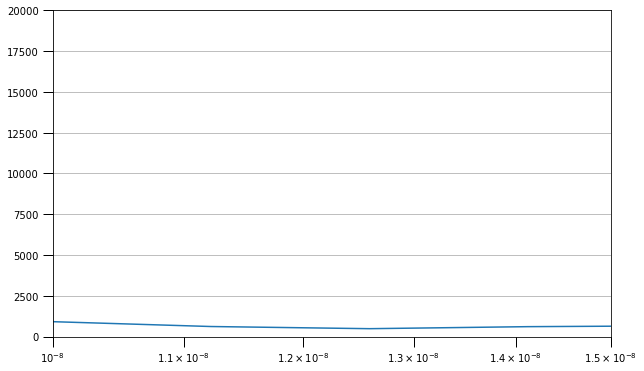

In [33]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1.5e-8, 0, 20000])

In [25]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [34]:
# Set the learning rate
learning_rate = 1e-8

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [35]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 93.8169 - mae: 94.3155
Epoch 2/100
100/100 [==============================] - 1s 5ms/step - loss: 84.5809 - mae: 85.0795
Epoch 3/100
100/100 [==============================] - 1s 5ms/step - loss: 83.8109 - mae: 84.3095
Epoch 4/100
100/100 [==============================] - 1s 5ms/step - loss: 85.1646 - mae: 85.6635
Epoch 5/100
100/100 [==============================] - 1s 5ms/step - loss: 85.4892 - mae: 85.9879
Epoch 6/100
100/100 [==============================] - 1s 5ms/step - loss: 82.8456 - mae: 83.3442
Epoch 7/100
100/100 [==============================] - 1s 5ms/step - loss: 84.8170 - mae: 85.3153
Epoch 8/100
100/100 [==============================] - 1s 6ms/step - loss: 83.7926 - mae: 84.2914
Epoch 9/100
100/100 [==============================] - 1s 5ms/step - loss: 84.2274 - mae: 84.7258
Epoch 10/100
100/100 [==============================] - 1s 5ms/step - loss: 84.0906 - mae: 84.5894
Epoch 11/100
100/10

100/100 [==============================] - 1s 5ms/step - loss: 80.3751 - mae: 80.8733
Epoch 84/100
100/100 [==============================] - 1s 5ms/step - loss: 80.5458 - mae: 81.0447
Epoch 85/100
100/100 [==============================] - 1s 4ms/step - loss: 81.5914 - mae: 82.0899
Epoch 86/100
100/100 [==============================] - 1s 5ms/step - loss: 80.3455 - mae: 80.8444
Epoch 87/100
100/100 [==============================] - 1s 4ms/step - loss: 79.7277 - mae: 80.2264
Epoch 88/100
100/100 [==============================] - 1s 4ms/step - loss: 80.5894 - mae: 81.0882
Epoch 89/100
100/100 [==============================] - 1s 5ms/step - loss: 81.2529 - mae: 81.7515
Epoch 90/100
100/100 [==============================] - 1s 7ms/step - loss: 79.8309 - mae: 80.3292
Epoch 91/100
100/100 [==============================] - 1s 7ms/step - loss: 80.7479 - mae: 81.2466
Epoch 92/100
100/100 [==============================] - 1s 6ms/step - loss: 83.1373 - mae: 83.6357
Epoch 93/100
100/100 [=

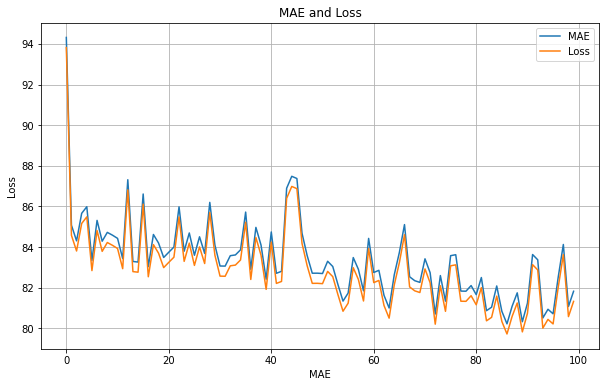

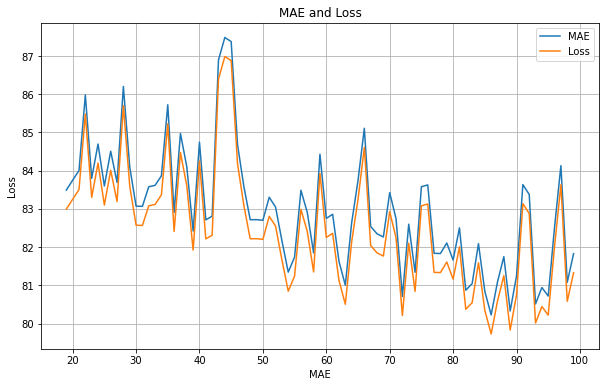

In [36]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [37]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

15/15 [==============================] - 0s 8ms/step


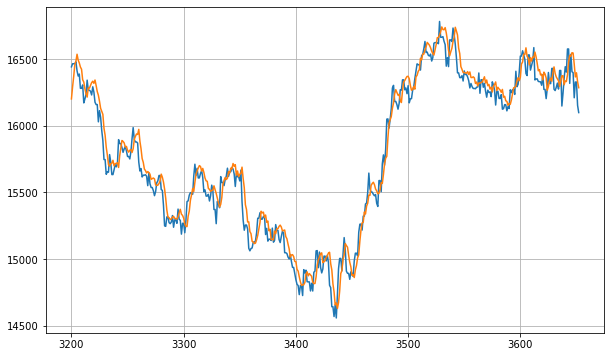

In [38]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

114/114 [==============================] - 1s 6ms/step


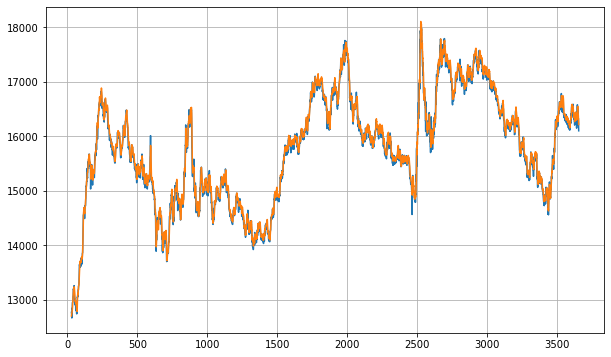

In [39]:
# Reduce the original series
forecast_series2 = series

# Use helper function to generate predictions
forecast2 = model_forecast(model, forecast_series2, window_size, batch_size)

# Drop single dimensional axis
results2 = forecast2.squeeze()
valid_y_series = series[window_size-1:]
valid_y_time = time[window_size-1:]

# Plot the results
plot_series(valid_y_time, (valid_y_series, results2))

In [40]:
# Compute the MAE valid
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

82.99298


In [41]:
print(f'2 last Actual Price = {x_valid[-2:]}, Predicted Price = {results[-2:]}')

2 last Actual Price = [16152.48258  16098.499876], Predicted Price = [16329.792 16285.091]


In [44]:
# import os
# path = "./saved_model"

# def get_model_dir():
#     """Returns the path where to save the current model.
#     The path is as follows: './saved_models/{incremental_integer}
#     Note: all sub-directories inside 'saved_models' must have an incremental integer as name

#     Returns:
#     - Path to save a new model (str) 
#     """
#     # create 'saved_models' directory if it does not exist
#     if not os.path.exists(path):
#         os.makedirs(path)

#     # check for model directories inside 'saved_models'
#     model_dirs = [int(i) for i in os.listdir(path)]

#     # if there is no prior model, current model has version 1
#     # otherwise, current model version is highest available version incremented by 1 
#     current_model = "1" if len(model_dirs)==0 else str(max(model_dirs)+1)

#     return path + "/" + current_model + "/"

In [45]:
# # !mkdir -p saved_model
# path = get_model_dir()
# model.save(path)

INFO:tensorflow:Assets written to: ./saved_model/2/assets


INFO:tensorflow:Assets written to: ./saved_model/2/assets


In [51]:
into_future = 100

# 1. Create function to make preds
def make_future_forecast(values, model, into_future, window_size=window_size) -> list:
    """
    Make future forecasts into_future steps after value ends.

    Returns future forecasts as a list of floats.
    """
    # 2. Create an empty list for future forecasts/prepare data to forecast on
    future_forecast = []
    last_window = values[-window_size:]

    # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
    for _ in range(into_future):
        # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

        # Append preds to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())

        # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
        last_window = np.append(last_window, future_pred)[-window_size:]

    return future_forecast
     

In [52]:
future_forecast = make_future_forecast(values=series,
                                       model=model,
                                       into_future=into_future,
                                       window_size=window_size)

1/1 [==============================] - 0s 17ms/step
Predicting on:
 [16203.089524 16280.630302 16399.092673 16318.476762 16315.231888
 16429.470394 16429.469488 16273.637841 16263.285891 16288.386835
 16319.517526 16274.713098 16414.111489 16414.120617 16147.622286
 16242.229701 16354.771363 16441.97451  16401.95819  16575.295115
 16575.295305 16317.496035 16535.081892 16404.251888 16398.471494
 16209.481958 16327.538019 16327.528027 16152.48258  16098.499876] -> Prediction: 16214.095703125

1/1 [==============================] - 0s 14ms/step
Predicting on:
 [16280.630302   16399.092673   16318.476762   16315.231888
 16429.470394   16429.469488   16273.637841   16263.285891
 16288.386835   16319.517526   16274.713098   16414.111489
 16414.120617   16147.622286   16242.229701   16354.771363
 16441.97451    16401.95819    16575.295115   16575.295305
 16317.496035   16535.081892   16404.251888   16398.471494
 16209.481958   16327.538019   16327.528027   16152.48258
 16098.499876   16214.0

1/1 [==============================] - 0s 21ms/step
Predicting on:
 [16354.771363   16441.97451    16401.95819    16575.295115
 16575.295305   16317.496035   16535.081892   16404.251888
 16398.471494   16209.481958   16327.538019   16327.528027
 16152.48258    16098.499876   16214.09570312 16276.13867188
 16203.6484375  16234.83984375 16219.96679688 16260.58203125
 16251.7734375  16326.9609375  16363.18652344 16331.359375
 16364.54199219 16369.68554688 16422.8515625  16402.9375
 16426.875      16445.5859375 ] -> Prediction: 16444.390625

1/1 [==============================] - 0s 31ms/step
Predicting on:
 [16441.97451    16401.95819    16575.295115   16575.295305
 16317.496035   16535.081892   16404.251888   16398.471494
 16209.481958   16327.538019   16327.528027   16152.48258
 16098.499876   16214.09570312 16276.13867188 16203.6484375
 16234.83984375 16219.96679688 16260.58203125 16251.7734375
 16326.9609375  16363.18652344 16331.359375   16364.54199219
 16369.68554688 16422.8515625  


1/1 [==============================] - 0s 33ms/step
Predicting on:
 [16276.13867188 16203.6484375  16234.83984375 16219.96679688
 16260.58203125 16251.7734375  16326.9609375  16363.18652344
 16331.359375   16364.54199219 16369.68554688 16422.8515625
 16402.9375     16426.875      16445.5859375  16444.390625
 16429.87109375 16452.8359375  16477.50390625 16483.33203125
 16479.76953125 16521.51757812 16539.7578125  16535.22460938
 16546.64648438 16581.8046875  16620.40625    16622.8203125
 16633.72265625 16657.51171875] -> Prediction: 16679.46875

1/1 [==============================] - 0s 34ms/step
Predicting on:
 [16203.6484375  16234.83984375 16219.96679688 16260.58203125
 16251.7734375  16326.9609375  16363.18652344 16331.359375
 16364.54199219 16369.68554688 16422.8515625  16402.9375
 16426.875      16445.5859375  16444.390625   16429.87109375
 16452.8359375  16477.50390625 16483.33203125 16479.76953125
 16521.51757812 16539.7578125  16535.22460938 16546.64648438
 16581.8046875  1662

1/1 [==============================] - 0s 29ms/step
Predicting on:
 [16444.390625   16429.87109375 16452.8359375  16477.50390625
 16483.33203125 16479.76953125 16521.51757812 16539.7578125
 16535.22460938 16546.64648438 16581.8046875  16620.40625
 16622.8203125  16633.72265625 16657.51171875 16679.46875
 16694.7265625  16722.40234375 16740.9921875  16749.12109375
 16764.25       16785.96875    16810.76171875 16816.45703125
 16840.14453125 16857.859375   16877.67578125 16889.4921875
 16909.51367188 16934.41796875] -> Prediction: 16949.716796875

1/1 [==============================] - 0s 33ms/step
Predicting on:
 [16429.87109375 16452.8359375  16477.50390625 16483.33203125
 16479.76953125 16521.51757812 16539.7578125  16535.22460938
 16546.64648438 16581.8046875  16620.40625    16622.8203125
 16633.72265625 16657.51171875 16679.46875    16694.7265625
 16722.40234375 16740.9921875  16749.12109375 16764.25
 16785.96875    16810.76171875 16816.45703125 16840.14453125
 16857.859375   16877.6

1/1 [==============================] - 0s 32ms/step
Predicting on:
 [16679.46875    16694.7265625  16722.40234375 16740.9921875
 16749.12109375 16764.25       16785.96875    16810.76171875
 16816.45703125 16840.14453125 16857.859375   16877.67578125
 16889.4921875  16909.51367188 16934.41796875 16949.71679688
 16967.86328125 16988.8359375  17010.76171875 17024.59375
 17043.31054688 17066.84375    17088.64648438 17104.43359375
 17121.45117188 17142.10742188 17161.4609375  17181.3046875
 17200.15429688 17220.50390625] -> Prediction: 17237.146484375

1/1 [==============================] - 0s 35ms/step
Predicting on:
 [16694.7265625  16722.40234375 16740.9921875  16749.12109375
 16764.25       16785.96875    16810.76171875 16816.45703125
 16840.14453125 16857.859375   16877.67578125 16889.4921875
 16909.51367188 16934.41796875 16949.71679688 16967.86328125
 16988.8359375  17010.76171875 17024.59375    17043.31054688
 17066.84375    17088.64648438 17104.43359375 17121.45117188
 17142.107421


1/1 [==============================] - 0s 28ms/step
Predicting on:
 [16949.71679688 16967.86328125 16988.8359375  17010.76171875
 17024.59375    17043.31054688 17066.84375    17088.64648438
 17104.43359375 17121.45117188 17142.10742188 17161.4609375
 17181.3046875  17200.15429688 17220.50390625 17237.14648438
 17255.94726562 17277.16015625 17297.24609375 17314.95703125
 17334.33007812 17355.05273438 17374.765625   17392.82617188
 17412.87304688 17433.61328125 17452.96875    17472.29296875
 17492.05078125 17512.42578125] -> Prediction: 17531.1640625

1/1 [==============================] - 0s 28ms/step
Predicting on:
 [16967.86328125 16988.8359375  17010.76171875 17024.59375
 17043.31054688 17066.84375    17088.64648438 17104.43359375
 17121.45117188 17142.10742188 17161.4609375  17181.3046875
 17200.15429688 17220.50390625 17237.14648438 17255.94726562
 17277.16015625 17297.24609375 17314.95703125 17334.33007812
 17355.05273438 17374.765625   17392.82617188 17412.87304688
 17433.613281

1/1 [==============================] - 0s 29ms/step
Predicting on:
 [17237.14648438 17255.94726562 17277.16015625 17297.24609375
 17314.95703125 17334.33007812 17355.05273438 17374.765625
 17392.82617188 17412.87304688 17433.61328125 17452.96875
 17472.29296875 17492.05078125 17512.42578125 17531.1640625
 17550.79296875 17571.515625   17591.640625   17610.625
 17629.95703125 17650.36328125 17670.31835938 17690.25390625
 17710.11132812 17730.28125    17749.73828125 17769.81054688
 17790.171875   17810.4375    ] -> Prediction: 17830.171875

1/1 [==============================] - 0s 31ms/step
Predicting on:
 [17255.94726562 17277.16015625 17297.24609375 17314.95703125
 17334.33007812 17355.05273438 17374.765625   17392.82617188
 17412.87304688 17433.61328125 17452.96875    17472.29296875
 17492.05078125 17512.42578125 17531.1640625  17550.79296875
 17571.515625   17591.640625   17610.625      17629.95703125
 17650.36328125 17670.31835938 17690.25390625 17710.11132812
 17730.28125    17749

In [45]:
next_time_steps = np.arange(time[-1] + 1, time[-1] + 1 + into_future)
next_time_steps

# Insert last timestep/final price into next time steps and future forecasts so the plot connects
next_time_steps = np.insert(next_time_steps, 0, time[-1])
future_forecast = np.insert(future_forecast, 0, series[-1])

In [46]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps ( a series of points in time) against values (a series of values across timesteps)

    Parameters
    ----------
    timesteps: array of timestep values
    values: array of values across time
    format: style of plot, default "."
    start: where to start the plot (setting a value will index from start of timesteps & values)
    end: where to end the plot (similar to start but for the end)
    label: label to show on plot about values, default None
    """

    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Day")
    plt.ylabel("EUR/IDR Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

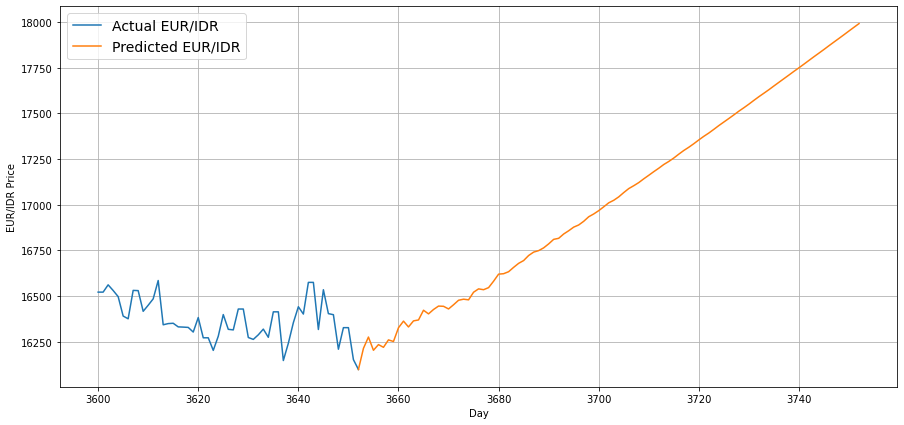

In [50]:
plt.figure(figsize=(15,7))
plot_time_series(time, series, start=3600, format="-", label="Actual EUR/IDR")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted EUR/IDR")

The model is overfitting, which is why this is a bad model